<h1 style="background-color:#C71585; color:white" style="font-family: Cambria" align="center">Predicting Future Sales using LightGBM Regression</h1> 

**Dataset:**

https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data

In this project, sales data in the 1-year period following the dates in the data set will be predicted daily.

<a id='import'></a>
<h1 style="background-color:#C71585; color:white" style="font-family: Cambria">Importing Basic Libraries and Loading Dataset</h1> 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from time import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
df= pd.read_csv('train.csv')
df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


<a id='understand'></a>
<h1 style="background-color:#C71585; color:white" style="font-family: Cambria">Understanding Dataset & EDA</h1> 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [4]:
from datetime import datetime, timedelta, date

df['date'] = pd.to_datetime(df['date'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [6]:
df['sales'].describe()

count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
25%          30.000000
50%          47.000000
75%          70.000000
max         231.000000
Name: sales, dtype: float64

No null value and no duplicate row:

In [7]:
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [9]:
df[df.duplicated()]

,date,store,item,sales


10 stores and 50 items:

In [10]:
df.store.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [11]:
df.store.nunique()

10

In [12]:
df.item.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
      dtype=int64)

In [13]:
df.item.nunique()

50

Let's create the total **daily, monthly and annual** sales data frames:

Daily total and mean:

In [14]:
data_day_sum= df.resample('D', on='date').sum()
data_day_sum.index= pd.to_datetime(data_day_sum.index).strftime('%Y-%m-%d')
data_day_sum['date']= data_day_sum.index
data_day_sum= pd.DataFrame(data_day_sum[['date',"sales"]])
data_day_sum= data_day_sum.reset_index(level=0, drop=True)
data_day_sum.head()

,date,sales
0,2013-01-01,13696
1,2013-01-02,13678
2,2013-01-03,14488
3,2013-01-04,15677
4,2013-01-05,16237


In [15]:
data_day_mean= df.resample('D', on='date').mean()
data_day_mean.index= pd.to_datetime(data_day_mean.index).strftime('%Y-%m-%d')
data_day_mean['date']= data_day_mean.index
data_day_mean= pd.DataFrame(data_day_mean[['date',"sales"]])
data_day_mean= data_day_mean.reset_index(level=0, drop=True)
data_day_mean.head()

,date,sales
0,2013-01-01,27.392
1,2013-01-02,27.356
2,2013-01-03,28.976
3,2013-01-04,31.354
4,2013-01-05,32.474


In [16]:
len(data_day_sum)

1826

Montly total and mean:

In [17]:
data_month_sum= df.resample('M', on='date').sum()
data_month_sum.index= pd.to_datetime(data_month_sum.index).strftime('%Y-%m')
data_month_sum['year_month']= data_month_sum.index
data_month_sum= pd.DataFrame(data_month_sum[['year_month',"sales"]])
data_month_sum= data_month_sum.reset_index(level=0, drop=True)
data_month_sum.head()

,year_month,sales
0,2013-01,454904
1,2013-02,459417
2,2013-03,617382
3,2013-04,682274
4,2013-05,763242


In [18]:
data_month_mean= df.resample('M', on='date').mean()
data_month_mean.index= pd.to_datetime(data_month_mean.index).strftime('%Y-%m')
data_month_mean['year_month']= data_month_mean.index
data_month_mean= pd.DataFrame(data_month_mean[['year_month',"sales"]])
data_month_mean= data_month_mean.reset_index(level=0, drop=True)
data_month_mean.head()

,year_month,sales
0,2013-01,29.348645
1,2013-02,32.815500
2,2013-03,39.831097
3,2013-04,45.484933
4,2013-05,49.241419


In [19]:
len(data_month_sum)

60

Annual total and mean:

In [20]:
data_year_sum= df.resample('Y', on='date').sum()
data_year_sum.index= pd.to_datetime(data_year_sum.index).strftime('%Y')
data_year_sum['year']= data_year_sum.index
data_year_sum= pd.DataFrame(data_year_sum[['year',"sales"]])
data_year_sum= data_year_sum.reset_index(level=0, drop=True)
data_year_sum.head()

,year,sales
0,2013,7941243
1,2014,9135482
2,2015,9536887
3,2016,10357160
4,2017,10733740


In [21]:
data_year_mean= df.resample('Y', on='date').mean()
data_year_mean.index= pd.to_datetime(data_year_mean.index).strftime('%Y')
data_year_mean['year']= data_year_mean.index
data_year_mean= pd.DataFrame(data_year_mean[['year',"sales"]])
data_year_mean= data_year_mean.reset_index(level=0, drop=True)
data_year_mean.head()

,year,sales
0,2013,43.513660
1,2014,50.057436
2,2015,52.256915
3,2016,56.596503
4,2017,58.815014


In [22]:
len(data_year_sum)

5

Let's assign the date column as the index:

In [23]:
data_day_sum= data_day_sum.set_index('date')
data_day_sum.index = pd.to_datetime(data_day_sum.index)

<AxesSubplot:xlabel='date'>

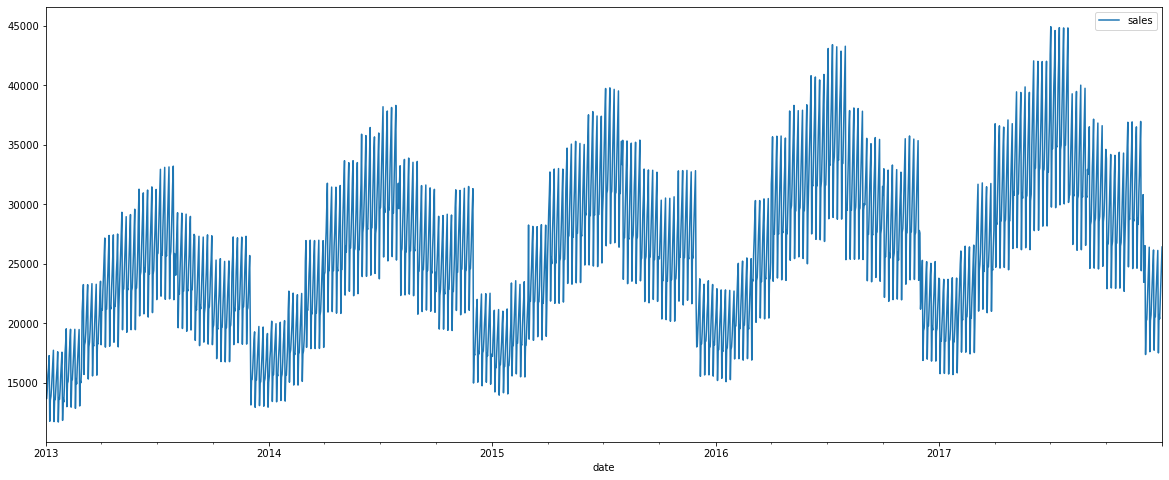

In [24]:
data_day_sum.plot(figsize=(20, 8))

**Our data seems not stationary because the average daily sales grow over time when we plot the total daily sales over time.**

If it is not stationary, we need to compute the difference between each day's sales and add it as a new column to our data frame to make it stationary.

We will address this issue in one of the next steps.

***Firstly, Some visualizations...***

In [25]:
#Sales Data Per Store

def total_sales_per_store(df):
    sales_by_store = df.groupby('store')['sales'].sum().reset_index()
    
    fig, ax = plt.subplots(figsize=(10,6))
    sns.barplot(sales_by_store.store, sales_by_store.sales, order=sales_by_store.sort_values('sales',ascending = False).store)
    
    ax.set(xlabel = "Store Id", ylabel = "Sum of Sales", title = "Total Sales Per Store")
    plt.xticks(fontsize=12, rotation=45)
    
    return sales_by_store

,store,sales
0,1,4315603
1,2,6120128
2,3,5435144
3,4,5012639
4,5,3631016
5,6,3627670
6,7,3320009
7,8,5856169
8,9,5025976
9,10,5360158


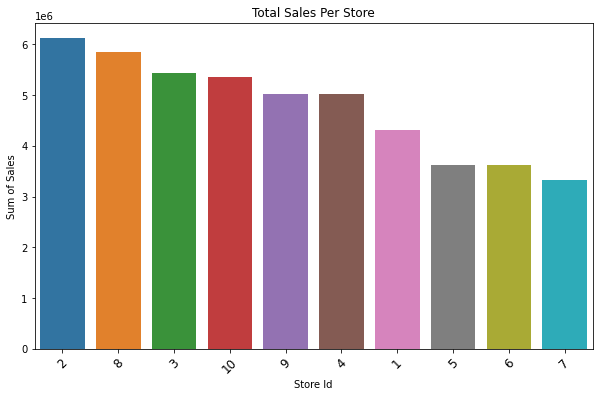

In [26]:
total_sales_per_store(df)

In [27]:
#Sales Data Per Item

def total_sales_per_item(df):
    sales_by_store = df.groupby('item')['sales'].sum().reset_index()
    
    fig, ax = plt.subplots(figsize=(20,8))
    sns.barplot(sales_by_store.item, sales_by_store.sales, order=sales_by_store.sort_values('sales', ascending = False).item)
    
    ax.set(xlabel = "Item Id", ylabel = "Sum of Sales", title = "Total Sales Per Item")
    plt.xticks(fontsize=12, rotation=90)
    
    return

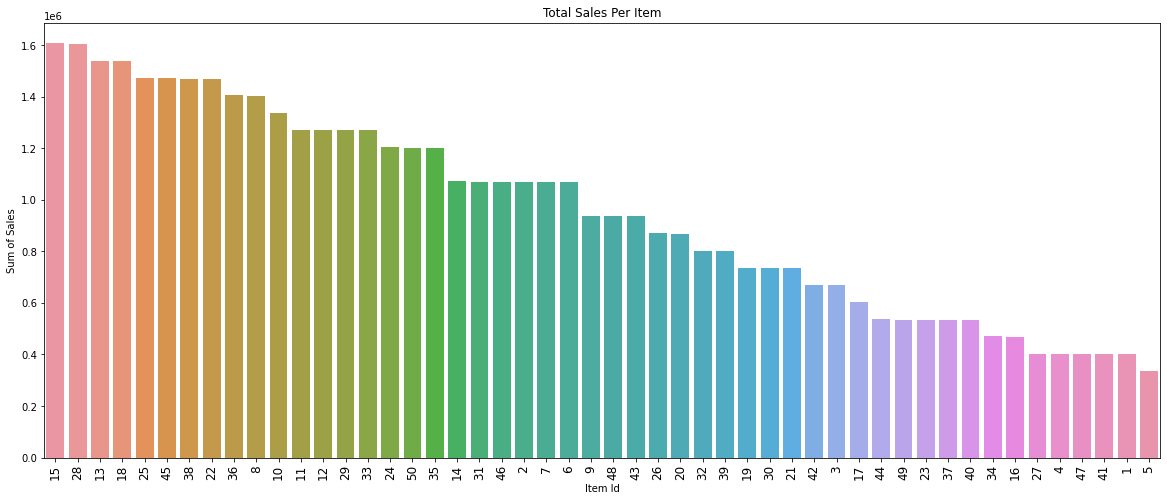

In [28]:
total_sales_per_item(df)

In [29]:
item_sales_per_store = df.groupby(['store', 'item'])['sales'].sum()
item_sales_per_store

store  item
1      1        36468
       2        97050
       3        60638
       4        36440
       5        30335
                ...  
10     46      120601
       47       45204
       48      105570
       49       60317
       50      135192
Name: sales, Length: 500, dtype: int64

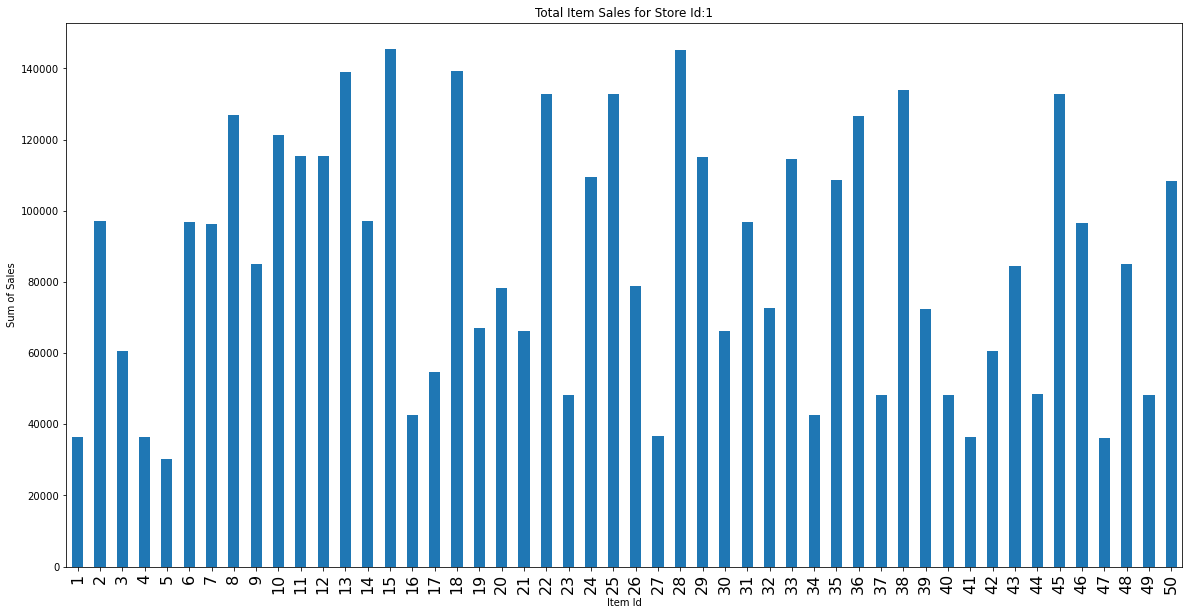

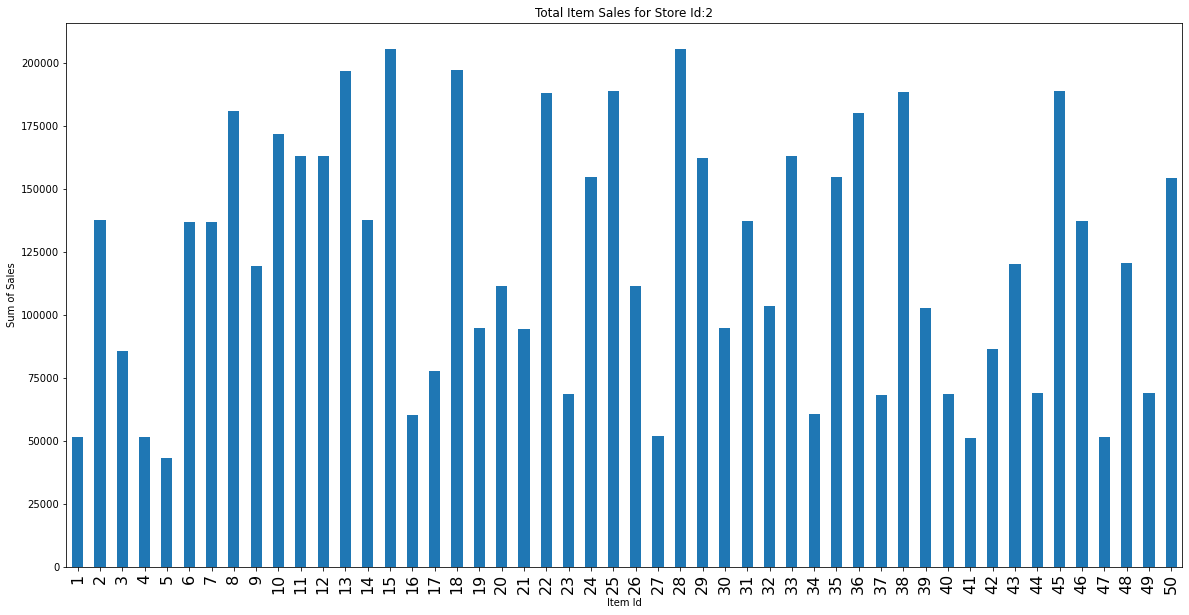

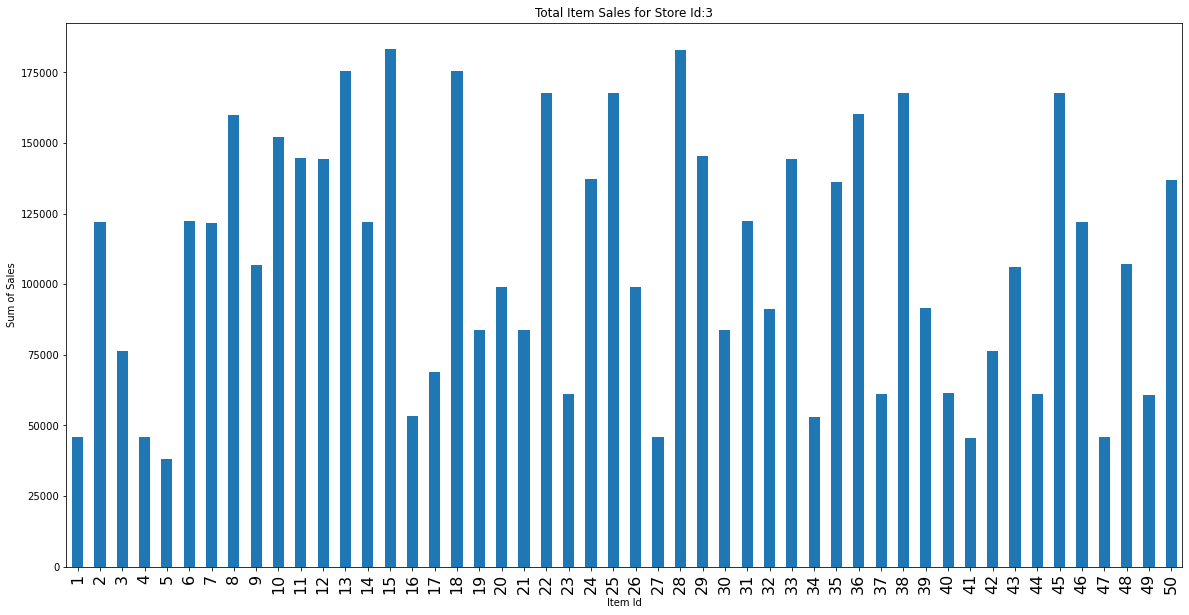

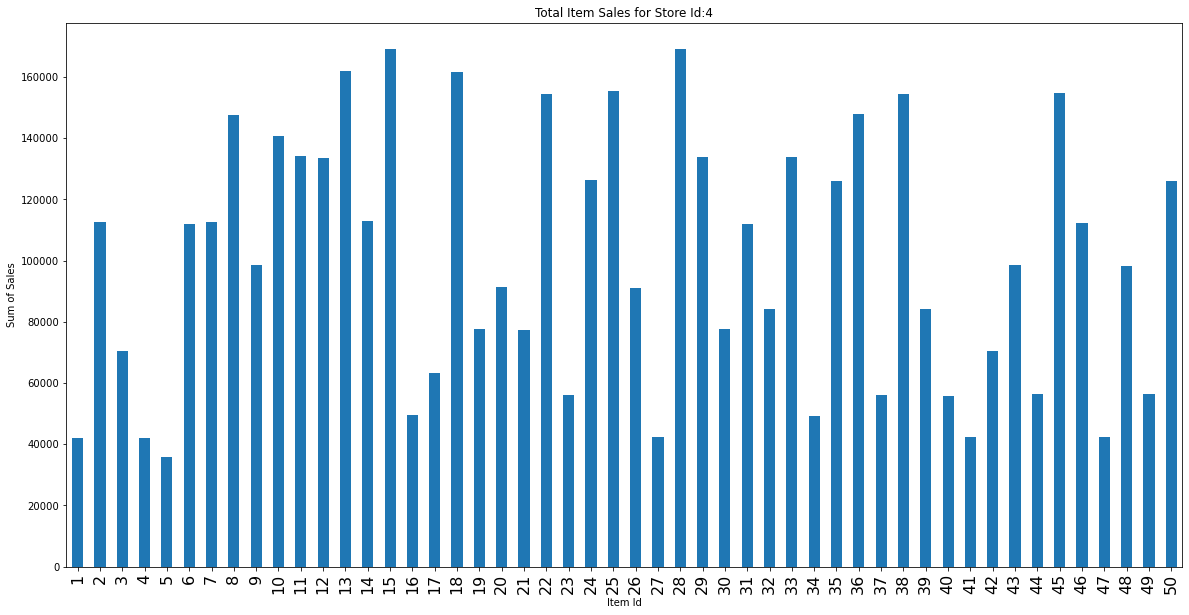

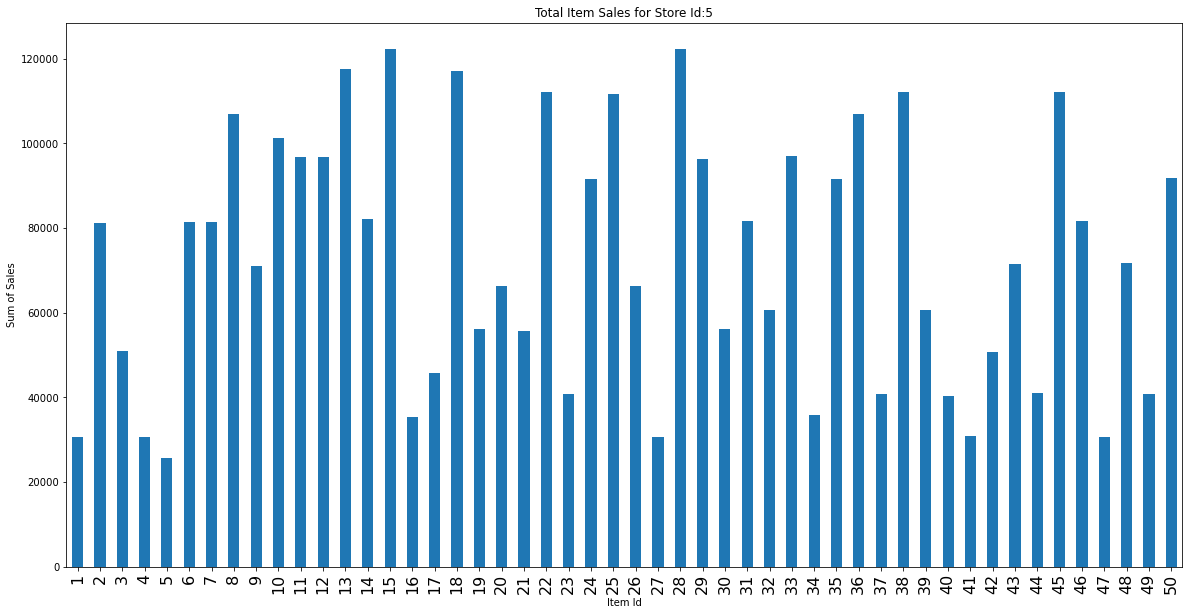

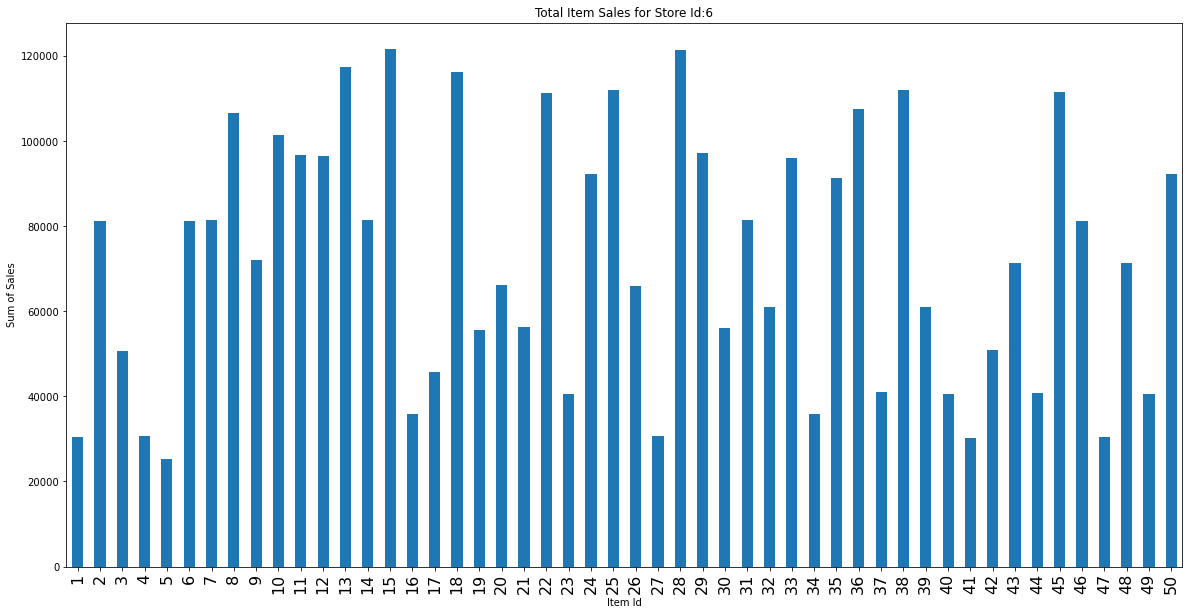

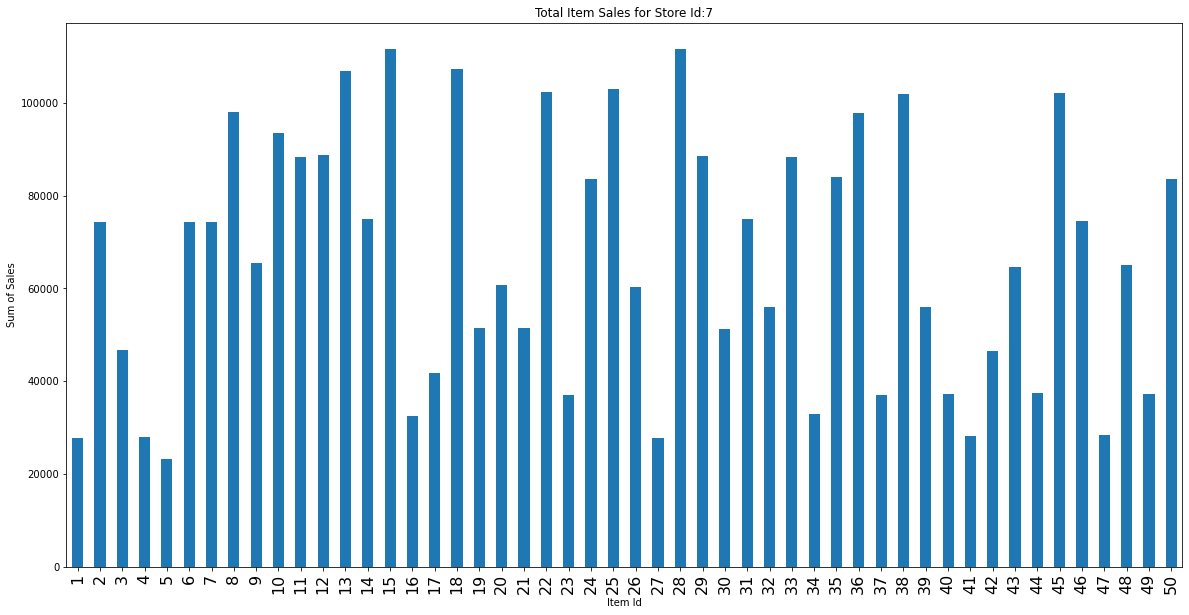

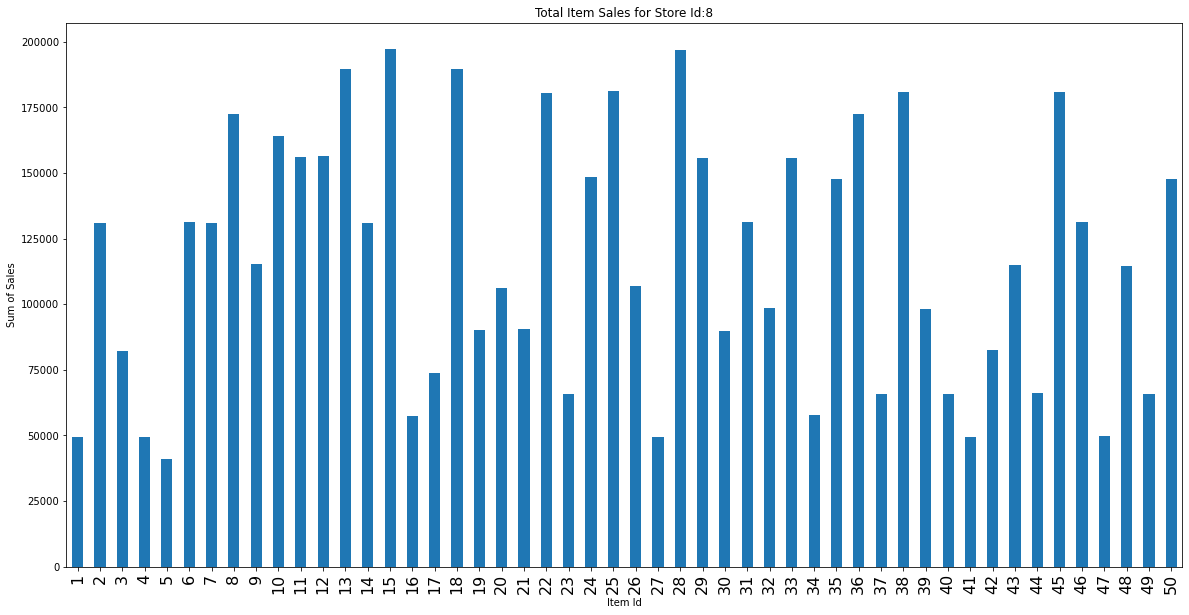

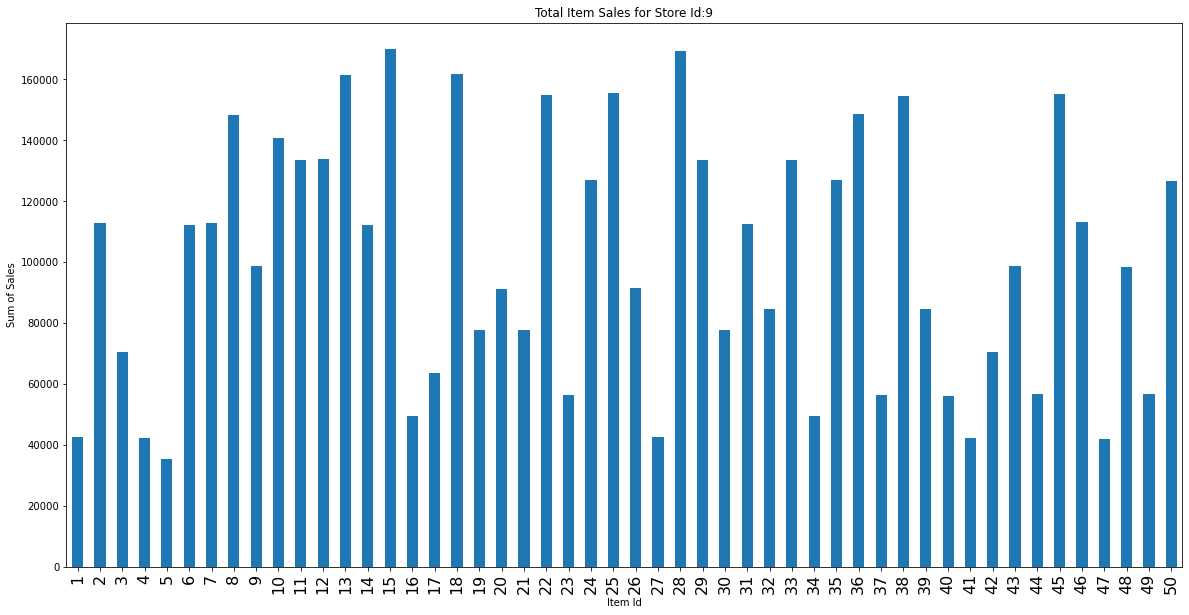

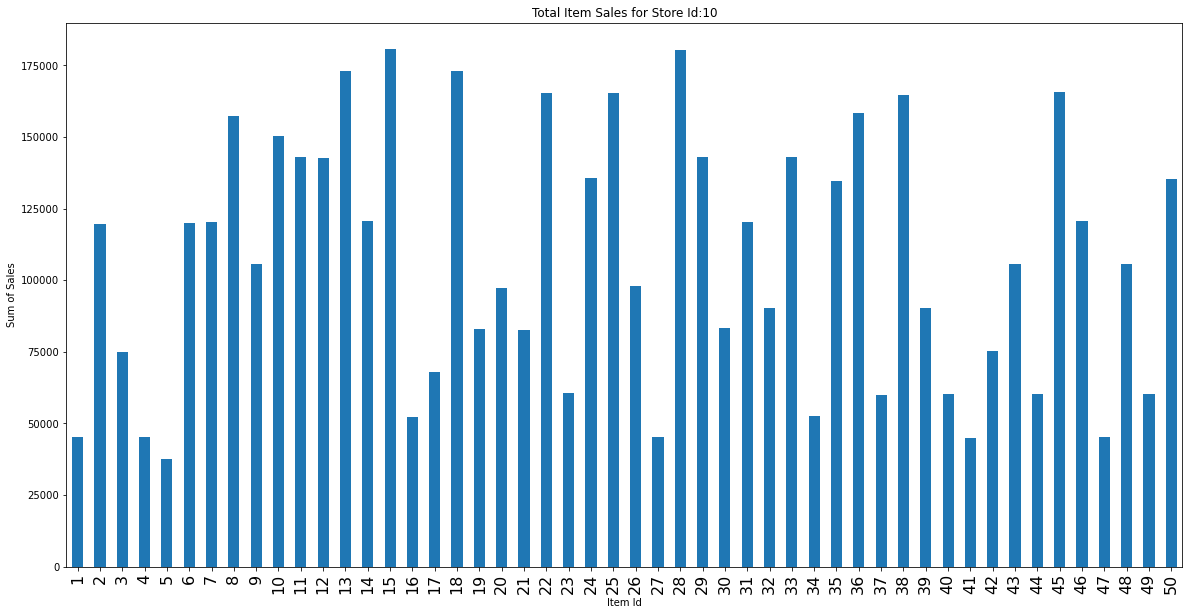

In [30]:
for i in df.store.unique():
    plt.figure(figsize=(20,10))
    item_sales_per_store.loc[i,:].plot(kind= "bar")
    plt.xlabel("Item Id"),
    plt.ylabel("Sum of Sales")
    plt.title("Total Item Sales for Store Id:{}".format(i))
    plt.xticks(fontsize=16, rotation=90)
    plt.show();

In [31]:
#other method
item_sales_per_store_df= pd.DataFrame(df.groupby(['store', 'item'])['sales'].sum())
item_sales_per_store_df.reset_index(inplace=True)
item_sales_per_store_df

,store,item,sales
0,1,1,36468
1,1,2,97050
2,1,3,60638
3,1,4,36440
4,1,5,30335
...,...,...,...
495,10,46,120601
496,10,47,45204
497,10,48,105570
498,10,49,60317


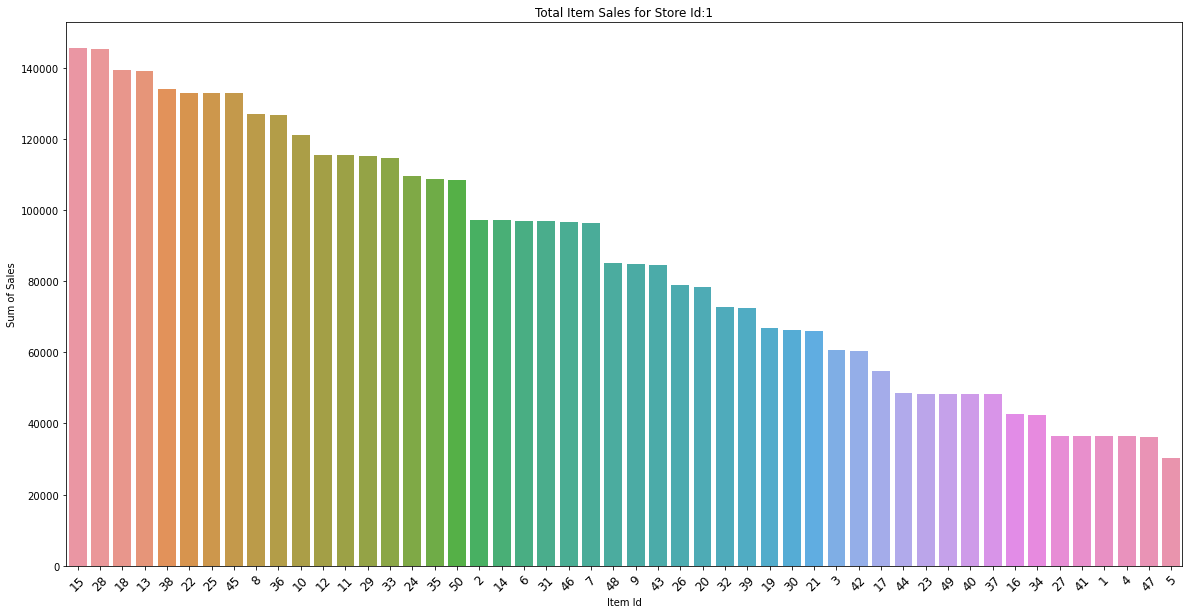

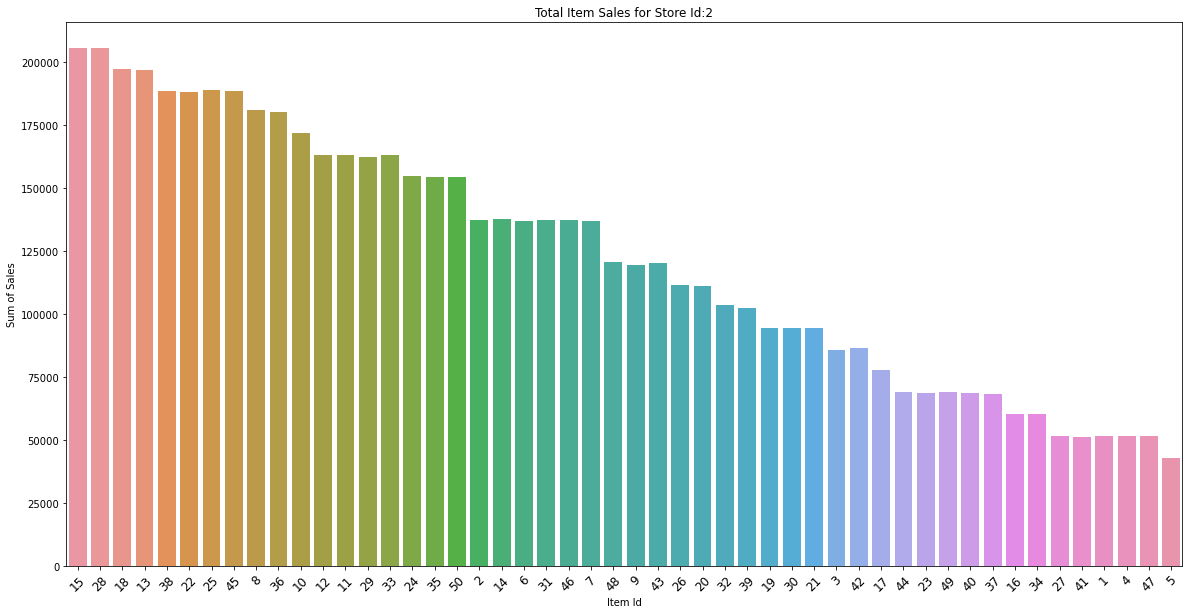

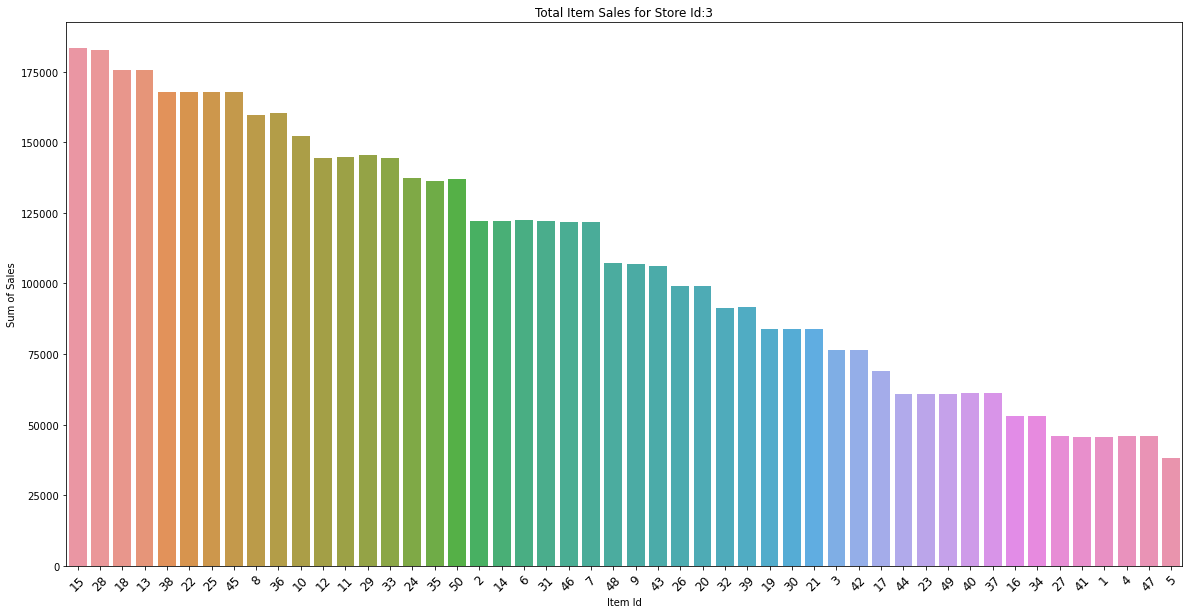

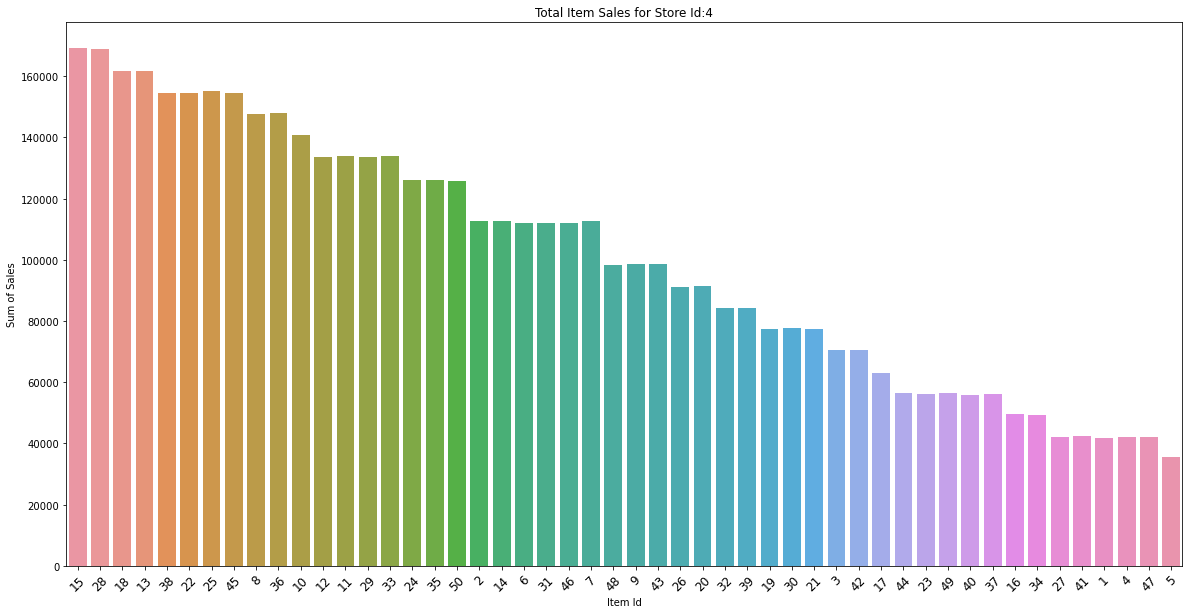

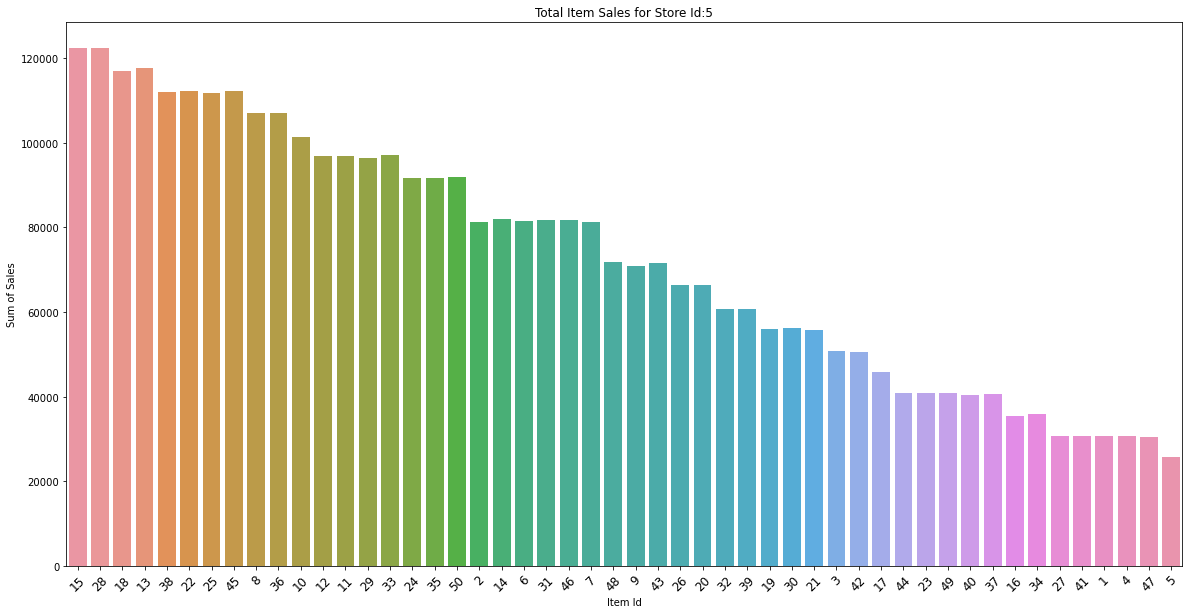

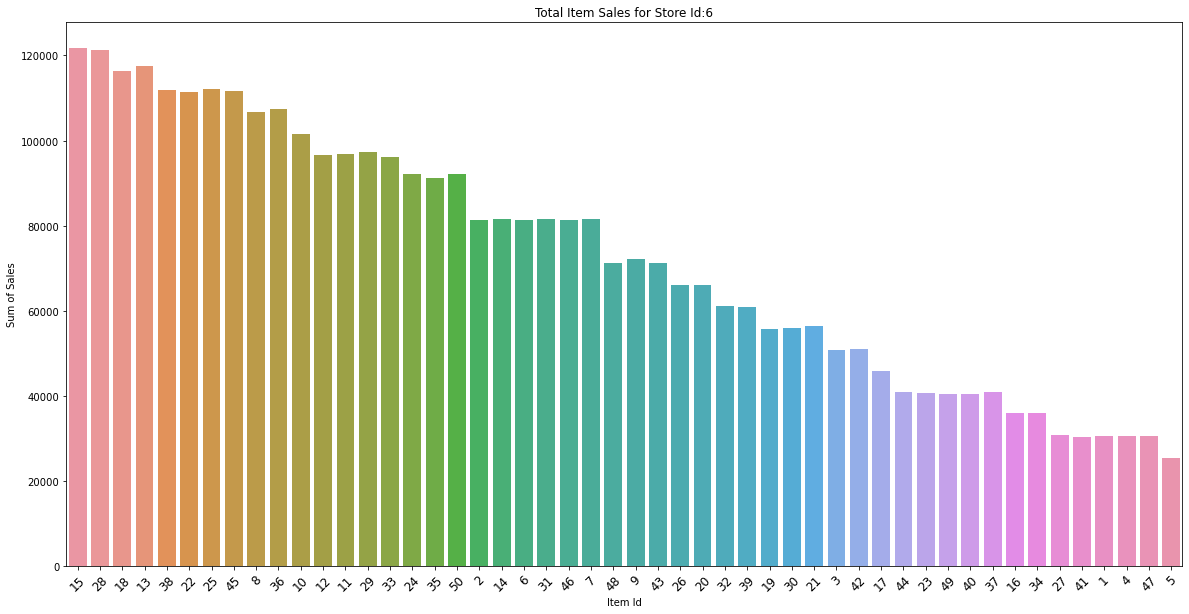

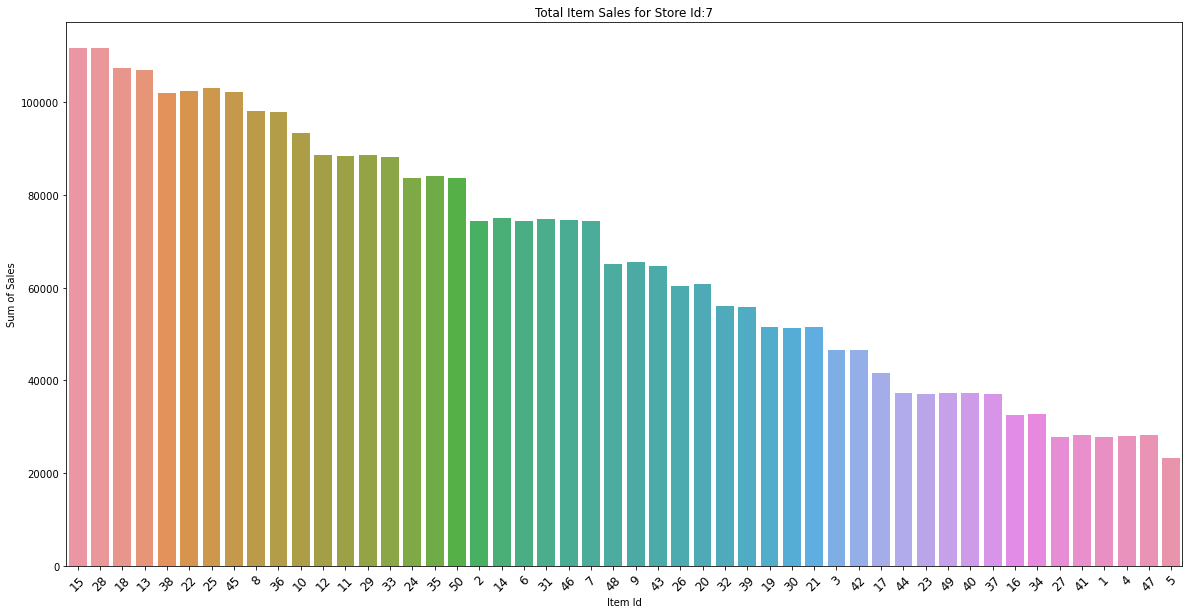

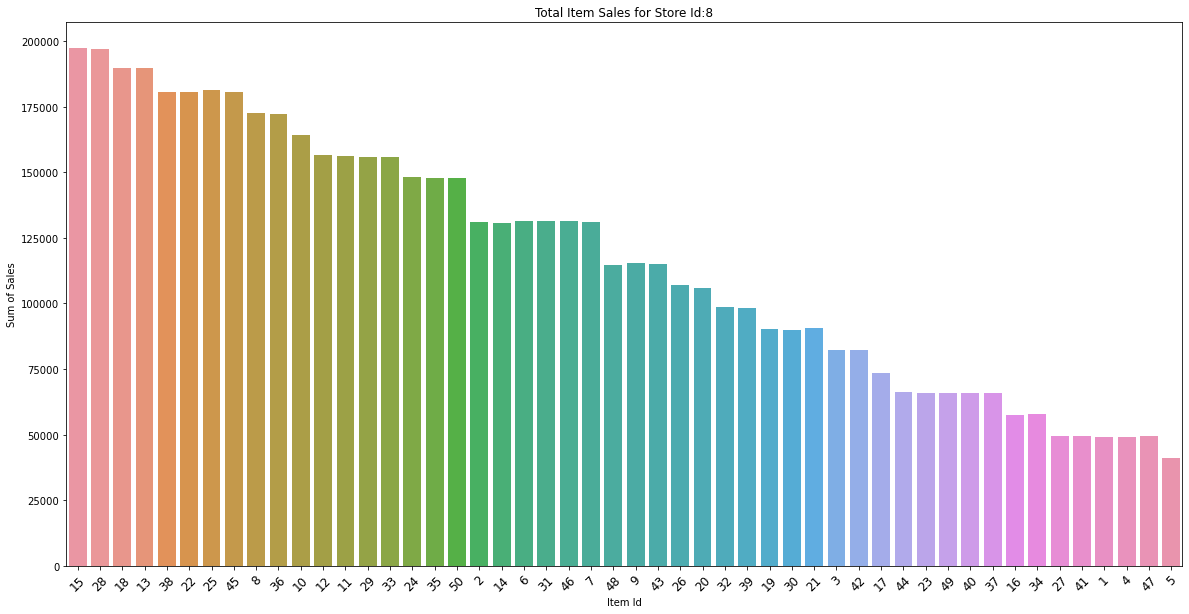

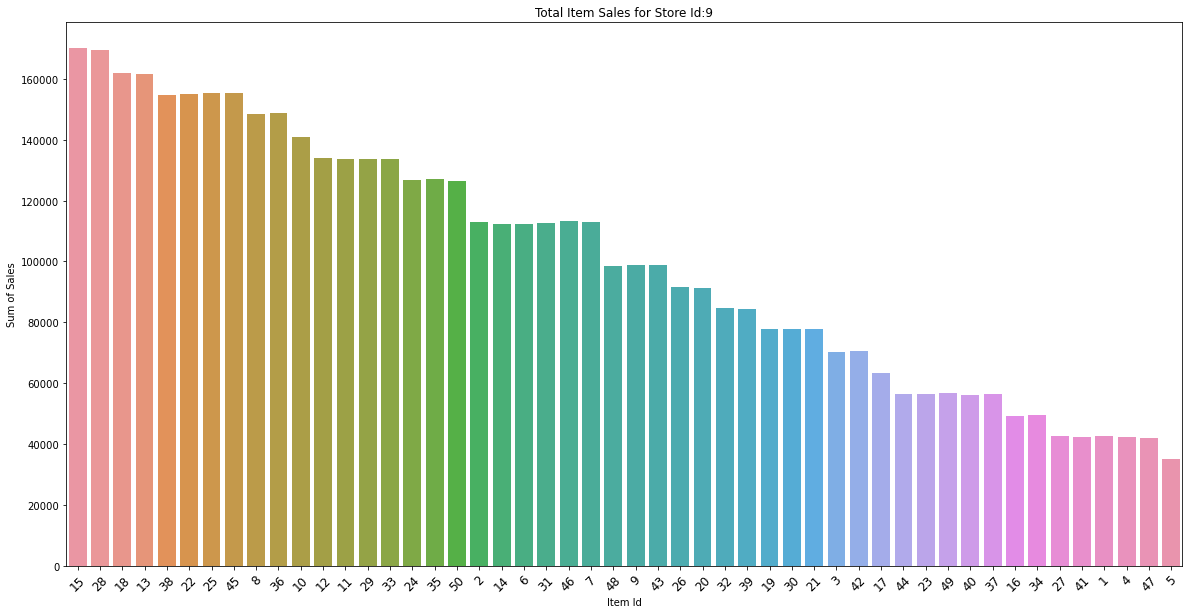

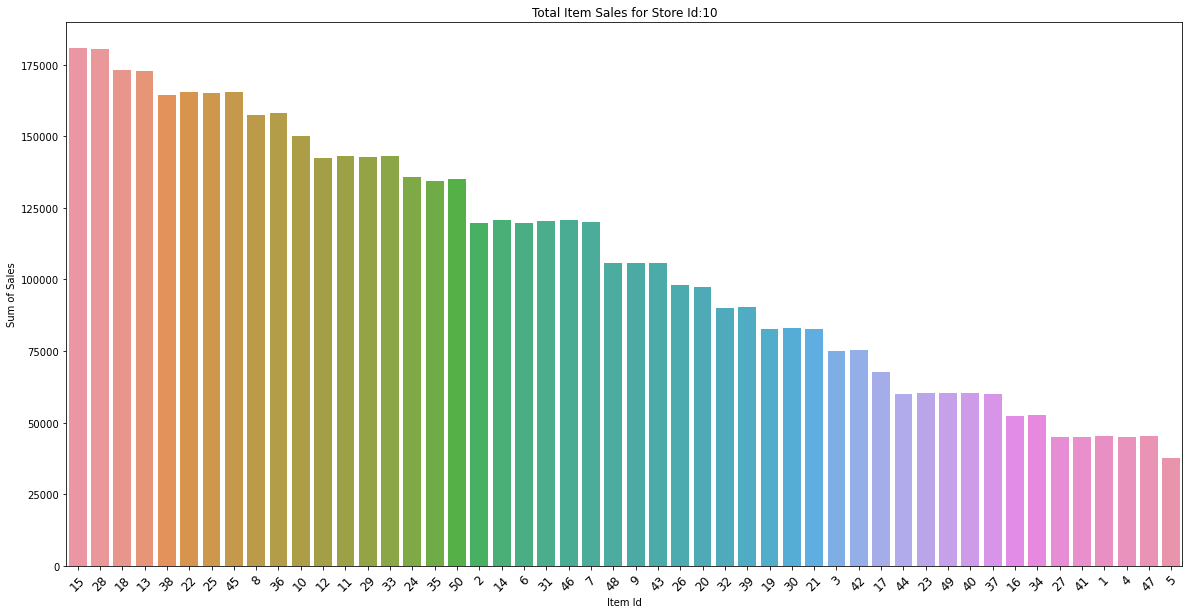

In [32]:
for i in df.store.unique():
    plt.figure(figsize=(20,10))
    sns.barplot(x = 'item', y = 'sales', data= item_sales_per_store_df.loc[item_sales_per_store_df.store==i], 
                order=item_sales_per_store_df.loc[item_sales_per_store_df.store==1].sort_values('sales', ascending = False).item)
    plt.xlabel("Item Id"),
    plt.ylabel("Sum of Sales")
    plt.title("Total Item Sales for Store Id:{}".format(i))
    plt.xticks(fontsize=12, rotation=45)
    plt.show();

<a id='fe'></a>
<h1 style="background-color:#C71585; color:white" style="font-family: Cambria">Future Engineering</h1> 

We said that our data seems that it is not stationary, and to make it stationary, we will calculate the difference between the sales of each month and add it as a new column to our data frame.

Let's check it:

<AxesSubplot:xlabel='date'>

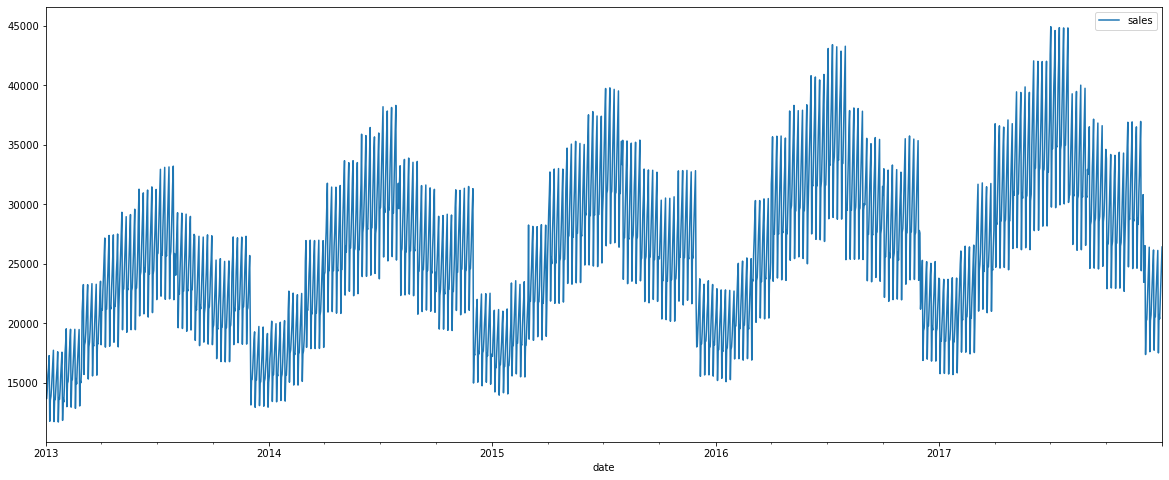

In [33]:
data_day_sum.plot(figsize=(20, 8))

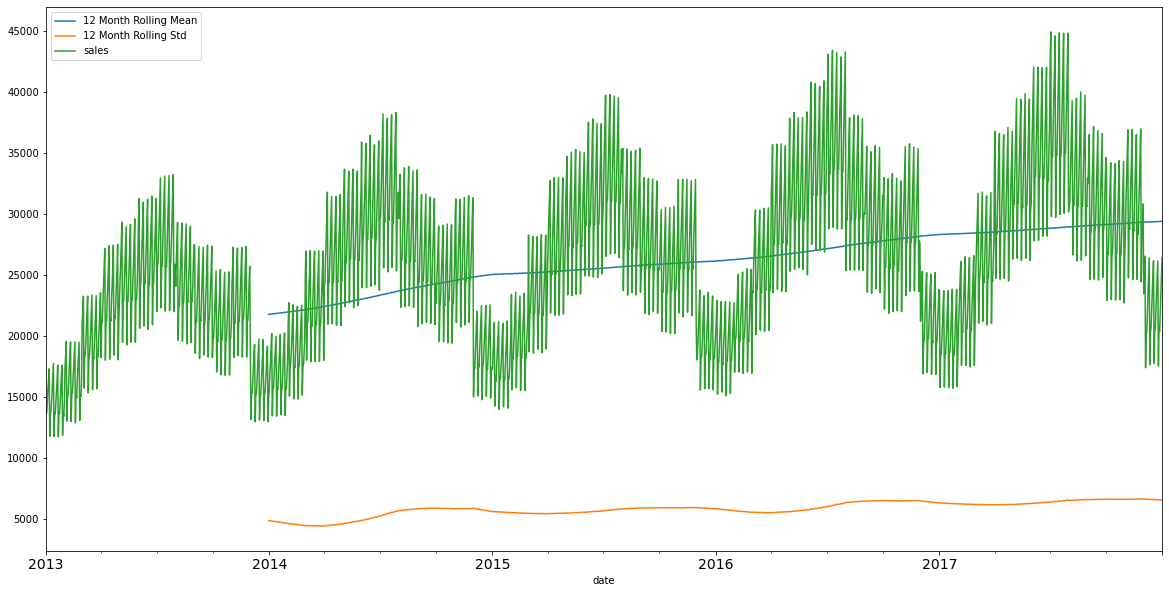

In [34]:
plt.figure(figsize=(20,10))
timeseries= data_day_sum["sales"]
timeseries.rolling(365).mean().plot(label='12 Month Rolling Mean')
timeseries.rolling(365).std().plot(label='12 Month Rolling Std')
timeseries.plot()
plt.legend()
plt.xticks(fontsize=14)
plt.show();

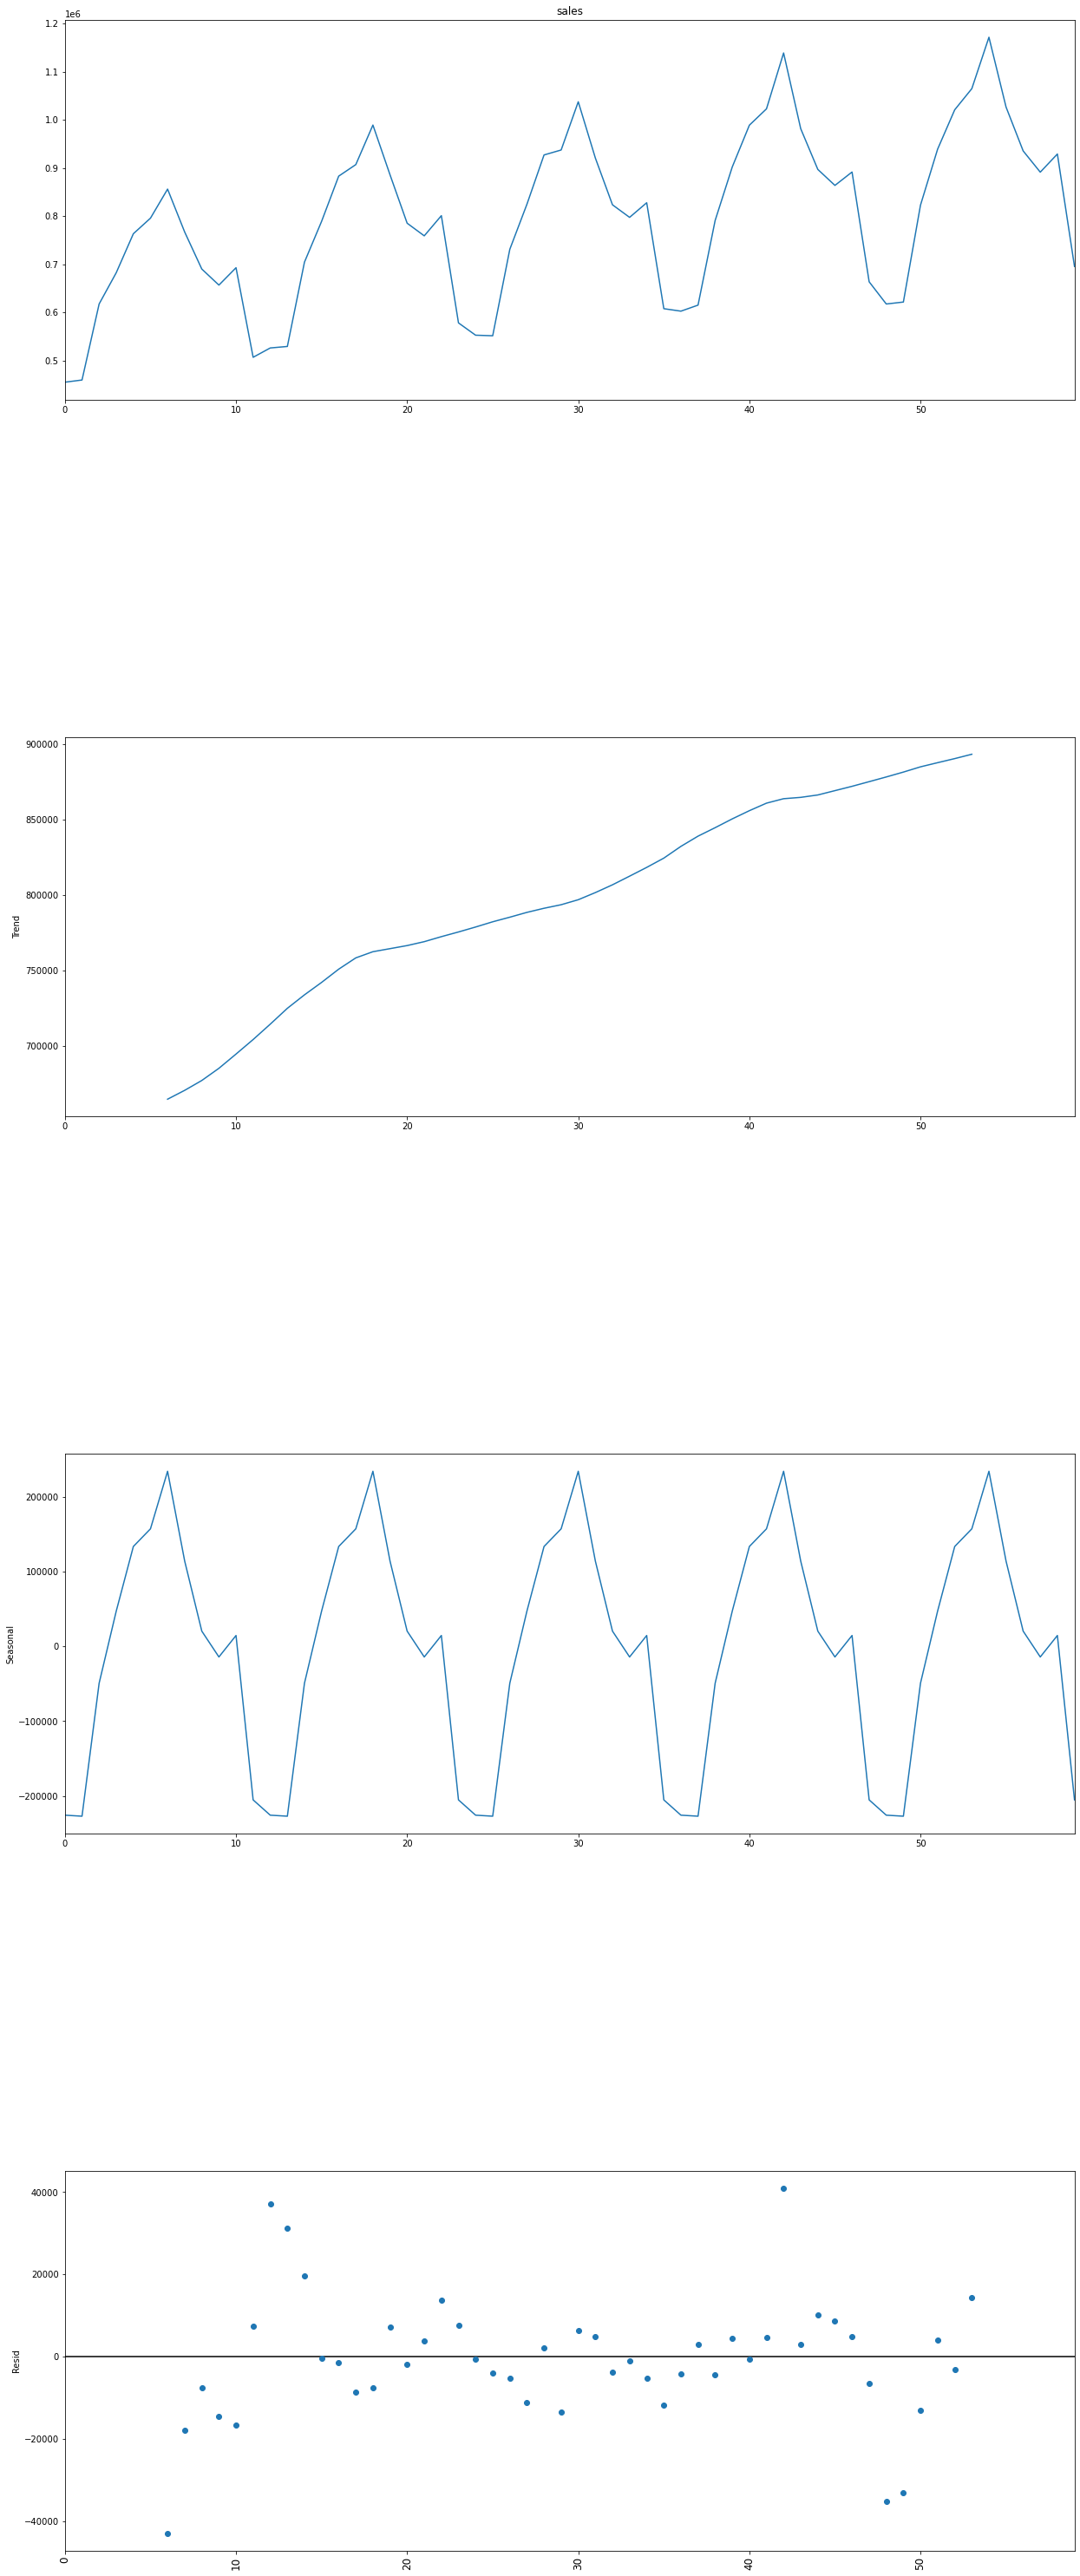

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data_month_sum["sales"], period=12)  

#figure= plt.figure()  
decomposition.plot().set_size_inches(20, 50)
plt.xticks(fontsize=12, rotation=90);

Source: https://www.mygreatlearning.com/blog/time-series-analysis-and-forecasting/

The data is indeed seasonal and follows an upward trend. Also, the average value or the mean of the residuals seem to be zero which holds our assumption.

The data is non-stationary so we need to apply differencing to make our data stationary.

In [36]:
data_day_sum

,sales
date,
2013-01-01,13696
2013-01-02,13678
2013-01-03,14488
2013-01-04,15677
2013-01-05,16237
...,...
2017-12-27,20378
2017-12-28,21885
2017-12-29,23535


In [37]:
#create a new dataframe to model the difference
df_diff= data_day_sum.copy()

#add previous sales to the next row
df_diff['prev_sales'] = df_diff.shift(freq='1D')['sales']

#drop the null values and calculate the difference
df_diff = df_diff.dropna()
df_diff['diff']= (df_diff['sales'] - df_diff['prev_sales'])
df_diff.head(10)

,sales,prev_sales,diff
date,,,
2013-01-02,13678,13696.0,-18.0
2013-01-03,14488,13678.0,810.0
2013-01-04,15677,14488.0,1189.0
2013-01-05,16237,15677.0,560.0
2013-01-06,17291,16237.0,1054.0
2013-01-07,11769,17291.0,-5522.0
2013-01-08,13560,11769.0,1791.0
2013-01-09,13878,13560.0,318.0
2013-01-10,14642,13878.0,764.0


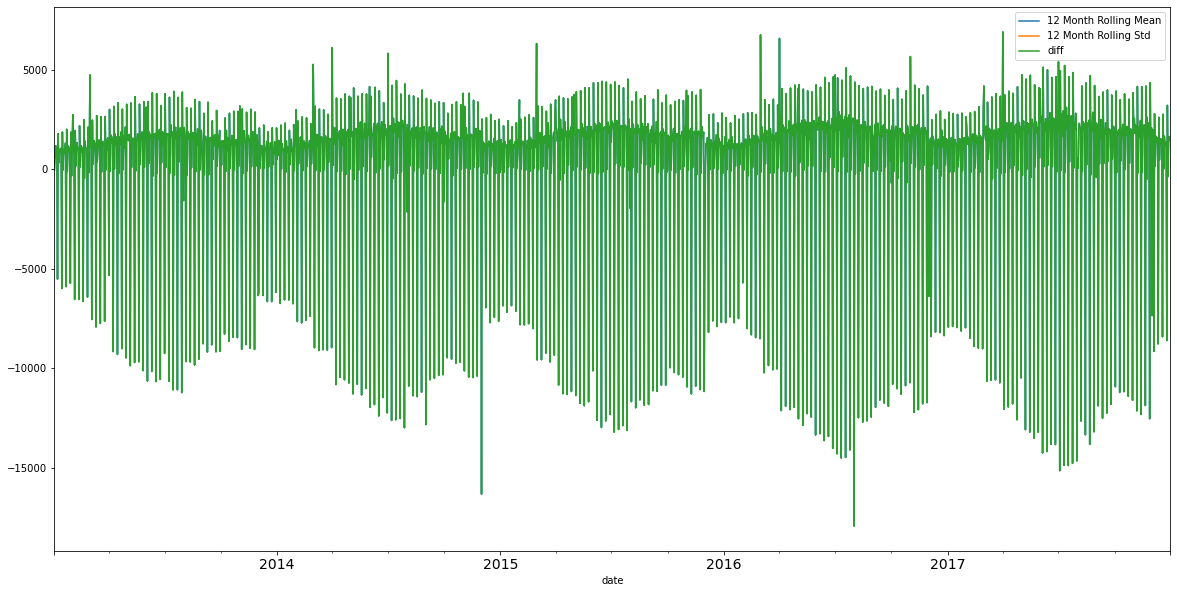

In [38]:
plt.figure(figsize=(20,10))
timeseries= df_diff["diff"]
timeseries.rolling(1).mean().plot(label='12 Month Rolling Mean')
timeseries.rolling(1).std().plot(label='12 Month Rolling Std')
timeseries.plot()
plt.legend()
plt.xticks(fontsize=14)
plt.show();

We have stabilised our data.

To forecast upcoming daily sales, we must use data from previous days.

For each model, the look-back period may be different. 

We can choose 4 for lag (total year range, same-day sales in previous years).

Source: https://machinelearningmastery.com/feature-selection-time-series-forecasting-python/

In [39]:
from dateutil.relativedelta import relativedelta, MO

df_lag= df_diff.copy()

total_year= relativedelta(df_lag.index.max(), df_lag.index.min()).years

for column in range(1, total_year+1):
    column_name = 'lag_' + str(column)
    df_lag[column_name]= ""
    df_lag[column_name] = pd.to_numeric(df_lag[column_name])

df_lag.head()

,sales,prev_sales,diff,lag_1,lag_2,lag_3,lag_4
date,,,,,,,
2013-01-02,13678,13696.0,-18.0,NaN,NaN,NaN,NaN
2013-01-03,14488,13678.0,810.0,NaN,NaN,NaN,NaN
2013-01-04,15677,14488.0,1189.0,NaN,NaN,NaN,NaN
2013-01-05,16237,15677.0,560.0,NaN,NaN,NaN,NaN
2013-01-06,17291,16237.0,1054.0,NaN,NaN,NaN,NaN


In [40]:
def add_lags(df):
    target_map = df['sales'].to_dict()
    
    for i in range(1, total_year+1):
        df["lag_"+ str(i)] = (df.index - pd.DateOffset(years= i)).map(target_map)
        
    return df
    #df.dropna(inplace=True)
    #return df

In [41]:
df_lags = add_lags(df_lag)
df_lags

,sales,prev_sales,diff,lag_1,lag_2,lag_3,lag_4
date,,,,,,,
2013-01-02,13678,13696.0,-18.0,NaN,NaN,NaN,NaN
2013-01-03,14488,13678.0,810.0,NaN,NaN,NaN,NaN
2013-01-04,15677,14488.0,1189.0,NaN,NaN,NaN,NaN
2013-01-05,16237,15677.0,560.0,NaN,NaN,NaN,NaN
2013-01-06,17291,16237.0,1054.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2017-12-27,20378,20738.0,-360.0,19341.0,23268.0,21317.0,17047.0
2017-12-28,21885,20378.0,1507.0,19560.0,15569.0,22532.0,18433.0
2017-12-29,23535,21885.0,1650.0,21111.0,18403.0,14888.0,19148.0


Date time features are features created from the time stamp value of each observation. Let's create them:

In [42]:
def create_date_time_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['month'] = df.index.month
    df['day_of_month'] = df.index.day
    df['day_of_year'] = df.index.dayofyear
    df['week_of_year'] = df.index.weekofyear
    df['day_of_week'] = df.index.weekday
    df['year'] = df.index.year
    df['quarter'] = df.index.quarter
    df["is_wknd"] = (df.index.weekday > 4).astype(int)
    df['is_month_start'] = df.index.is_month_start.astype(int)
    df['is_month_end'] = df.index.is_month_end.astype(int)
    return df

In [43]:
df_supervised= create_date_time_features(df_lags)
df_supervised

,sales,prev_sales,diff,lag_1,lag_2,lag_3,lag_4,month,day_of_month,day_of_year,week_of_year,day_of_week,year,quarter,is_wknd,is_month_start,is_month_end
date,,,,,,,,,,,,,,,,,
2013-01-02,13678,13696.0,-18.0,NaN,NaN,NaN,NaN,1,2,2,1,2,2013,1,0,0,0
2013-01-03,14488,13678.0,810.0,NaN,NaN,NaN,NaN,1,3,3,1,3,2013,1,0,0,0
2013-01-04,15677,14488.0,1189.0,NaN,NaN,NaN,NaN,1,4,4,1,4,2013,1,0,0,0
2013-01-05,16237,15677.0,560.0,NaN,NaN,NaN,NaN,1,5,5,1,5,2013,1,1,0,0
2013-01-06,17291,16237.0,1054.0,NaN,NaN,NaN,NaN,1,6,6,1,6,2013,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,20378,20738.0,-360.0,19341.0,23268.0,21317.0,17047.0,12,27,361,52,2,2017,4,0,0,0
2017-12-28,21885,20378.0,1507.0,19560.0,15569.0,22532.0,18433.0,12,28,362,52,3,2017,4,0,0,0
2017-12-29,23535,21885.0,1650.0,21111.0,18403.0,14888.0,19148.0,12,29,363,52,4,2017,4,0,0,0


In [44]:
df_supervised= df_supervised.drop(['prev_sales'], axis=1)
df_supervised

,sales,diff,lag_1,lag_2,lag_3,lag_4,month,day_of_month,day_of_year,week_of_year,day_of_week,year,quarter,is_wknd,is_month_start,is_month_end
date,,,,,,,,,,,,,,,,
2013-01-02,13678,-18.0,NaN,NaN,NaN,NaN,1,2,2,1,2,2013,1,0,0,0
2013-01-03,14488,810.0,NaN,NaN,NaN,NaN,1,3,3,1,3,2013,1,0,0,0
2013-01-04,15677,1189.0,NaN,NaN,NaN,NaN,1,4,4,1,4,2013,1,0,0,0
2013-01-05,16237,560.0,NaN,NaN,NaN,NaN,1,5,5,1,5,2013,1,1,0,0
2013-01-06,17291,1054.0,NaN,NaN,NaN,NaN,1,6,6,1,6,2013,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,20378,-360.0,19341.0,23268.0,21317.0,17047.0,12,27,361,52,2,2017,4,0,0,0
2017-12-28,21885,1507.0,19560.0,15569.0,22532.0,18433.0,12,28,362,52,3,2017,4,0,0,0
2017-12-29,23535,1650.0,21111.0,18403.0,14888.0,19148.0,12,29,363,52,4,2017,4,0,0,0


In [45]:
df_supervised.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2013-01-02 to 2017-12-31
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sales           1825 non-null   int64  
 1   diff            1825 non-null   float64
 2   lag_1           1460 non-null   float64
 3   lag_2           1095 non-null   float64
 4   lag_3           730 non-null    float64
 5   lag_4           364 non-null    float64
 6   month           1825 non-null   int64  
 7   day_of_month    1825 non-null   int64  
 8   day_of_year     1825 non-null   int64  
 9   week_of_year    1825 non-null   int64  
 10  day_of_week     1825 non-null   int64  
 11  year            1825 non-null   int64  
 12  quarter         1825 non-null   int64  
 13  is_wknd         1825 non-null   int32  
 14  is_month_start  1825 non-null   int32  
 15  is_month_end    1825 non-null   int32  
dtypes: float64(5), int32(3), int64(8)
memory usage: 221.0 KB


<a id='split'></a>
<h1 style="background-color:#C71585; color:white" style="font-family: Cambria">Splitting Train and Test</h1>

We splitted our data into train and test sets. As the test set, we have selected the last 12 months’ sales.

In [46]:
train= df_supervised.loc[df_supervised.index < '2017-01-01']
test = df_supervised.loc[df_supervised.index >= '2017-01-01']

In [47]:
df_supervised.columns

Index(['sales', 'diff', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'month',
       'day_of_month', 'day_of_year', 'week_of_year', 'day_of_week', 'year',
       'quarter', 'is_wknd', 'is_month_start', 'is_month_end'],
      dtype='object')

In [48]:
FEATURES = ['diff', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'month',
       'day_of_month', 'day_of_year', 'week_of_year', 'day_of_week', 'year',
       'quarter', 'is_wknd', 'is_month_start', 'is_month_end']

TARGET = 'sales'

In [49]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

<a id='model'></a>
<h1 style="background-color:#C71585; color:white" style="font-family: Cambria">Building and Running LGBM Regressor</h1>

In [50]:
import lightgbm as lgb

In [51]:
model = lgb.LGBMRegressor()

In [52]:
from sklearn.metrics import explained_variance_score,mean_absolute_error, mean_squared_error, r2_score

In [53]:
%%time
start = time()
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=100)
train_time = time() - start
start = time()
y_pred = model.predict(X_test)
predict_time = time()-start    
print(model)
print("\tTraining time: %0.3fs" % train_time)
print("\tPrediction time: %0.3fs" % predict_time)
print("\tExplained variance:", explained_variance_score(y_test, y_pred))
print("\tMean absolute error (MAE):", mean_absolute_error(y_test, y_pred))
print("\tRoot Mean squared error (RMSE):",  np.sqrt(mean_squared_error(y_test, y_pred)))
print("\tR2 score:", r2_score(y_test, y_pred))
print()

[100]	training's l2: 40514.9	valid_1's l2: 2.53743e+06
LGBMRegressor()
	Training time: 0.243s
	Prediction time: 0.004s
	Explained variance: 0.9529802450723186
	Mean absolute error (MAE): 1261.2531572607875
	Root Mean squared error (RMSE): 1592.9317247457209
	R2 score: 0.9400357739555137

CPU times: total: 516 ms
Wall time: 255 ms


Metrics:

- Explained variance: 0.9529
- Mean absolute error (MAE): 1261.2531
- Root Mean squared error (RMSE): 1592.9317
- R2 score: 0.9400

<a id='cross'></a>
<h1 style="background-color:#C71585; color:white" style="font-family: Cambria">Cross Validation</h1>

In [54]:
from sklearn.model_selection import cross_val_score
Cross_validation_score= round(np.mean(cross_val_score(model, X_train, y_train, cv=10)), 3)
Cross_validation_score

0.878

<a id='gridcv'></a>
<h1 style="background-color:#C71585; color:white" style="font-family: Cambria">Grid Search CV</h1>

In [57]:
%%time
from sklearn.model_selection import GridSearchCV

parameters= {'max_depth': [3, 6, 10],
             'learning_rate': [0.01, 0.05, 0.1],
             'num_iterations': [10, 50, 100, 200, 500, 1000],
             'n_estimators': [100, 500, 1000]
            }

LGBM_grid = GridSearchCV(model, parameters, cv= 10, n_jobs=-1, verbose=True)

LGBM_grid.fit(X_train, y_train)

train_time = time() - start
start = time()
y_pred = LGBM_grid.predict(X_test)
predict_time = time()-start    
print("GridCV_model")
print("\tTraining time: %0.3fs" % train_time)
print("\tPrediction time: %0.3fs" % predict_time)
print("\tExplained variance:", explained_variance_score(y_test, y_pred))
print("\tMean absolute error (MAE):", mean_absolute_error(y_test, y_pred))
print("\tRoot Mean squared error (RMSE):",  np.sqrt(mean_squared_error(y_test, y_pred)))
print("\tR2 score:", r2_score(y_test, y_pred))
print()

print(LGBM_grid.best_score_)
print(LGBM_grid.best_params_)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits
GridCV_model
	Training time: 242.631s
	Prediction time: 0.019s
	Explained variance: 0.9681575722249322
	Mean absolute error (MAE): 894.2531545968357
	Root Mean squared error (RMSE): 1171.8869768683196
	R2 score: 0.967545915309998

0.9268254904387667
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'num_iterations': 1000}
CPU times: total: 8.45 s
Wall time: 3min 15s


Some improvement was observed in metrics.

<a id='fi'></a>
<h1 style="background-color:#C71585; color:white" style="font-family: Cambria">Feature Importances</h1>

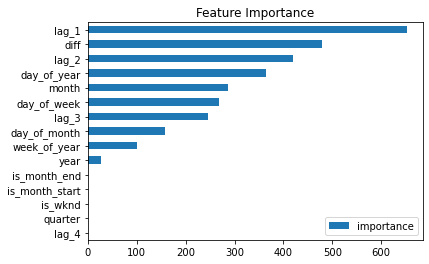

In [163]:
feature_importance= pd.DataFrame(data   = model.feature_importances_,
                                 index  = model.feature_name_,
                                 columns= ['importance'])
feature_importance.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.legend(loc='lower right')
plt.show()

<a id='test'></a>
<h1 style="background-color:#C71585; color:white" style="font-family: Cambria">Predictions for the Test Data </h1> 

Let's test our model on the test dataset.

In [154]:
test['pred']= y_pred

df_result= df_supervised.merge(test[['pred']], how='left', left_index=True, right_index=True)
df_result

,sales,diff,lag_1,lag_2,lag_3,lag_4,month,day_of_month,day_of_year,week_of_year,day_of_week,year,quarter,is_wknd,is_month_start,is_month_end,pred
date,,,,,,,,,,,,,,,,,
2013-01-02,13678,-18.0,NaN,NaN,NaN,NaN,1,2,2,1,2,2013,1,0,0,0,NaN
2013-01-03,14488,810.0,NaN,NaN,NaN,NaN,1,3,3,1,3,2013,1,0,0,0,NaN
2013-01-04,15677,1189.0,NaN,NaN,NaN,NaN,1,4,4,1,4,2013,1,0,0,0,NaN
2013-01-05,16237,560.0,NaN,NaN,NaN,NaN,1,5,5,1,5,2013,1,1,0,0,NaN
2013-01-06,17291,1054.0,NaN,NaN,NaN,NaN,1,6,6,1,6,2013,1,1,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,20378,-360.0,19341.0,23268.0,21317.0,17047.0,12,27,361,52,2,2017,4,0,0,0,20796.543427
2017-12-28,21885,1507.0,19560.0,15569.0,22532.0,18433.0,12,28,362,52,3,2017,4,0,0,0,21252.701154
2017-12-29,23535,1650.0,21111.0,18403.0,14888.0,19148.0,12,29,363,52,4,2017,4,0,0,0,23536.980491


we predicted for test set sales..

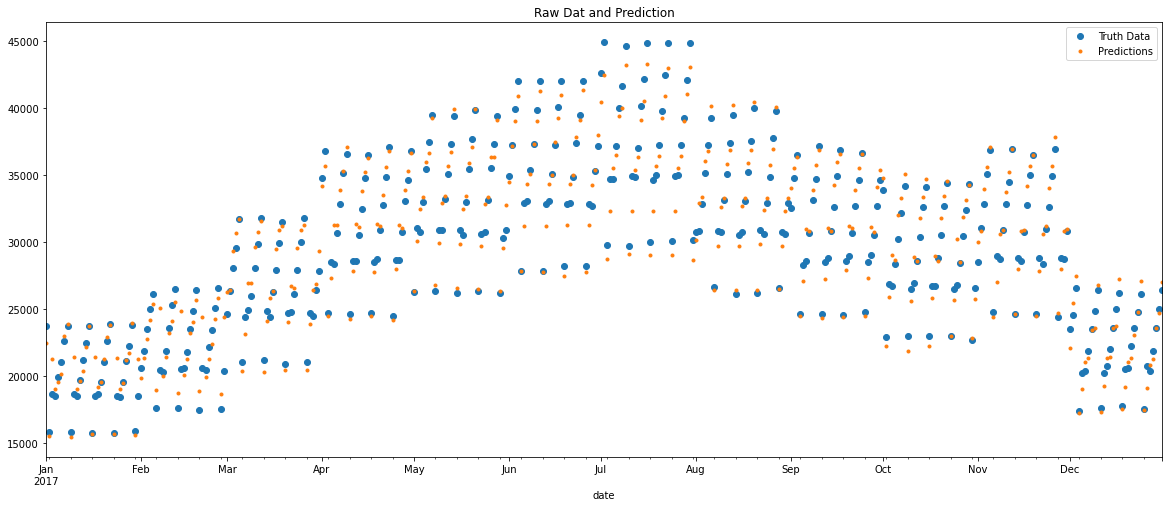

In [174]:
ax = df_result.loc[df_result.index >= '2017-01-01'][['sales']].plot(figsize=(20, 8), style='o')
df_result.loc[df_result.index >= '2017-01-01']['pred'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

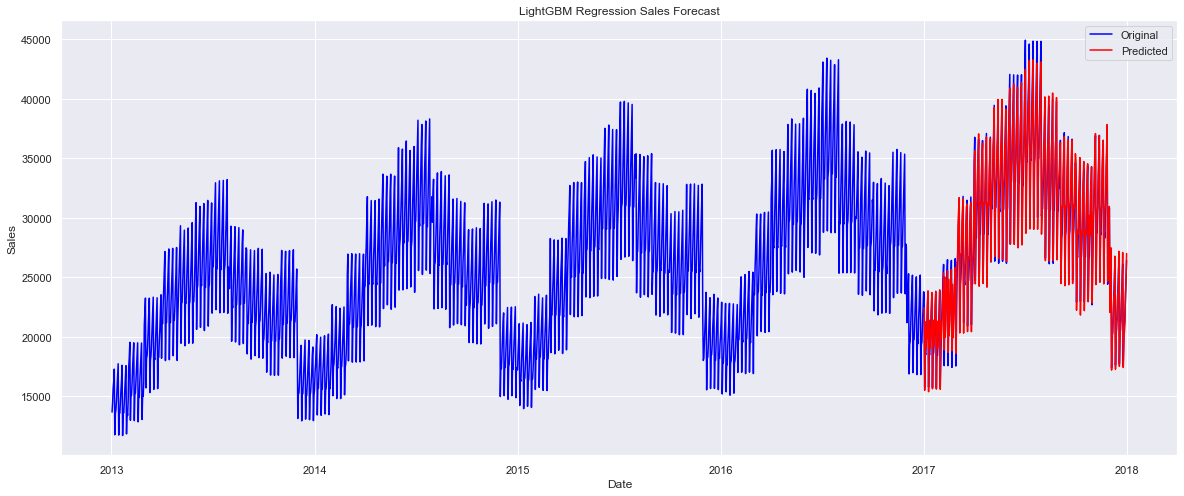

In [202]:
def plot_results(results, origin_df, model_name):

    fig, ax = plt.subplots(figsize=(20,8))
    sns.lineplot(origin_df.index, origin_df.sales, data=origin_df, ax=ax, 
                 label='Original', color='blue')
    sns.lineplot(results.index, results.pred, data=results, ax=ax, 
                 label='Predicted', color='red')
    
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecast")
    
    ax.legend(loc='best')

plot_results(df_result, df_supervised, 'LightGBM Regression')

<Figure size 1440x576 with 0 Axes>

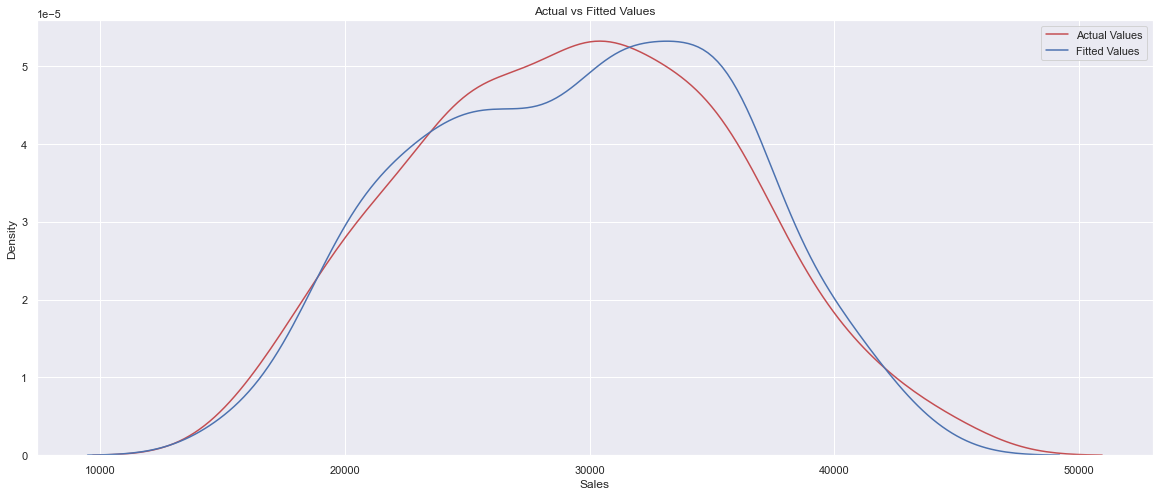

In [203]:
plt.figure()
fig, ax = plt.subplots(figsize=(20,8))
ax1 = sns.distplot(df_result.loc[df_result.index >= '2017-01-01']['sales'], hist=False, color="r", label="Actual Values")
sns.distplot(df_result.loc[df_result.index >= '2017-01-01'][['pred']], hist=False, color="b", label="Fitted Values" , ax=ax1)

plt.title('Actual vs Fitted Values')
plt.xlabel('Sales')
plt.legend(loc='best')
plt.show()
plt.close();

Nearly the same distribution

<a id='future'></a>
<h1 style="background-color:#C71585; color:white" style="font-family: Cambria">Predictions of Future Sales</h1>

Last day in our dataset:

In [175]:
data_day_sum.index.max()

Timestamp('2017-12-31 00:00:00')

Let's create a data frame including 1 year later from the last day in our dataset

In [176]:
future= pd.date_range(data_day_sum.index.max()+relativedelta(days=1),
                      data_day_sum.index.max()+relativedelta(years=1), 
                      freq='1d')
df_future= pd.DataFrame(index=future)
df_future

""
2018-01-01
2018-01-02
2018-01-03
2018-01-04
2018-01-05
...
2018-12-27
2018-12-28
2018-12-29
2018-12-30


In [178]:
df_future['isFuture'] = True
df_supervised['isFuture'] = False
data_and_future = pd.concat([df_supervised, df_future])
data_and_future

,sales,diff,lag_1,lag_2,lag_3,lag_4,month,day_of_month,day_of_year,week_of_year,day_of_week,year,quarter,is_wknd,is_month_start,is_month_end,isFuture
2013-01-02,13678.0,-18.0,NaN,NaN,NaN,NaN,1.0,2.0,2.0,1.0,2.0,2013.0,1.0,0.0,0.0,0.0,False
2013-01-03,14488.0,810.0,NaN,NaN,NaN,NaN,1.0,3.0,3.0,1.0,3.0,2013.0,1.0,0.0,0.0,0.0,False
2013-01-04,15677.0,1189.0,NaN,NaN,NaN,NaN,1.0,4.0,4.0,1.0,4.0,2013.0,1.0,0.0,0.0,0.0,False
2013-01-05,16237.0,560.0,NaN,NaN,NaN,NaN,1.0,5.0,5.0,1.0,5.0,2013.0,1.0,1.0,0.0,0.0,False
2013-01-06,17291.0,1054.0,NaN,NaN,NaN,NaN,1.0,6.0,6.0,1.0,6.0,2013.0,1.0,1.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2018-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2018-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2018-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


feature engineering...

In [179]:
data_and_future= create_date_time_features(data_and_future)
data_and_future

,sales,diff,lag_1,lag_2,lag_3,lag_4,month,day_of_month,day_of_year,week_of_year,day_of_week,year,quarter,is_wknd,is_month_start,is_month_end,isFuture
2013-01-02,13678.0,-18.0,NaN,NaN,NaN,NaN,1,2,2,1,2,2013,1,0,0,0,False
2013-01-03,14488.0,810.0,NaN,NaN,NaN,NaN,1,3,3,1,3,2013,1,0,0,0,False
2013-01-04,15677.0,1189.0,NaN,NaN,NaN,NaN,1,4,4,1,4,2013,1,0,0,0,False
2013-01-05,16237.0,560.0,NaN,NaN,NaN,NaN,1,5,5,1,5,2013,1,1,0,0,False
2013-01-06,17291.0,1054.0,NaN,NaN,NaN,NaN,1,6,6,1,6,2013,1,1,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,NaN,NaN,NaN,NaN,NaN,NaN,12,27,361,52,3,2018,4,0,0,0,True
2018-12-28,NaN,NaN,NaN,NaN,NaN,NaN,12,28,362,52,4,2018,4,0,0,0,True
2018-12-29,NaN,NaN,NaN,NaN,NaN,NaN,12,29,363,52,5,2018,4,1,0,0,True
2018-12-30,NaN,NaN,NaN,NaN,NaN,NaN,12,30,364,52,6,2018,4,1,0,0,True


In [180]:
data_and_future= add_lags(data_and_future)
data_and_future

,sales,diff,lag_1,lag_2,lag_3,lag_4,month,day_of_month,day_of_year,week_of_year,day_of_week,year,quarter,is_wknd,is_month_start,is_month_end,isFuture
2013-01-02,13678.0,-18.0,NaN,NaN,NaN,NaN,1,2,2,1,2,2013,1,0,0,0,False
2013-01-03,14488.0,810.0,NaN,NaN,NaN,NaN,1,3,3,1,3,2013,1,0,0,0,False
2013-01-04,15677.0,1189.0,NaN,NaN,NaN,NaN,1,4,4,1,4,2013,1,0,0,0,False
2013-01-05,16237.0,560.0,NaN,NaN,NaN,NaN,1,5,5,1,5,2013,1,1,0,0,False
2013-01-06,17291.0,1054.0,NaN,NaN,NaN,NaN,1,6,6,1,6,2013,1,1,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,NaN,NaN,20378.0,19341.0,23268.0,21317.0,12,27,361,52,3,2018,4,0,0,0,True
2018-12-28,NaN,NaN,21885.0,19560.0,15569.0,22532.0,12,28,362,52,4,2018,4,0,0,0,True
2018-12-29,NaN,NaN,23535.0,21111.0,18403.0,14888.0,12,29,363,52,5,2018,4,1,0,0,True
2018-12-30,NaN,NaN,24988.0,22296.0,18191.0,17407.0,12,30,364,52,6,2018,4,1,0,0,True


the date range we will predict:

In [181]:
future_df_with_features= data_and_future.query('isFuture').copy()
future_df_with_features

,sales,diff,lag_1,lag_2,lag_3,lag_4,month,day_of_month,day_of_year,week_of_year,day_of_week,year,quarter,is_wknd,is_month_start,is_month_end,isFuture
2018-01-01,NaN,NaN,23709.0,20158.0,17226.0,15556.0,1,1,1,1,0,2018,1,0,1,0,True
2018-01-02,NaN,NaN,15772.0,21280.0,18719.0,17033.0,1,2,2,1,1,2018,1,0,0,0,True
2018-01-03,NaN,NaN,18650.0,22911.0,19798.0,17746.0,1,3,3,1,2,2018,1,0,0,0,True
2018-01-04,NaN,NaN,18510.0,15199.0,21101.0,19184.0,1,4,4,1,3,2018,1,0,0,0,True
2018-01-05,NaN,NaN,19895.0,17806.0,14235.0,20182.0,1,5,5,1,4,2018,1,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,NaN,NaN,20378.0,19341.0,23268.0,21317.0,12,27,361,52,3,2018,4,0,0,0,True
2018-12-28,NaN,NaN,21885.0,19560.0,15569.0,22532.0,12,28,362,52,4,2018,4,0,0,0,True
2018-12-29,NaN,NaN,23535.0,21111.0,18403.0,14888.0,12,29,363,52,5,2018,4,1,0,0,True
2018-12-30,NaN,NaN,24988.0,22296.0,18191.0,17407.0,12,30,364,52,6,2018,4,1,0,0,True


predictions:

In [183]:
future_df_with_features['predictions']= LGBM_grid.predict(future_df_with_features[FEATURES])
future_df_with_features['predictions']

2018-01-01    22731.718455
2018-01-02    18096.673584
2018-01-03    19981.014417
2018-01-04    19697.629462
2018-01-05    20291.971723
                  ...     
2018-12-27    22245.920773
2018-12-28    24084.353451
2018-12-29    24460.625966
2018-12-30    28297.981893
2018-12-31    22836.967174
Name: predictions, Length: 365, dtype: float64

<AxesSubplot:ylabel='predictions'>

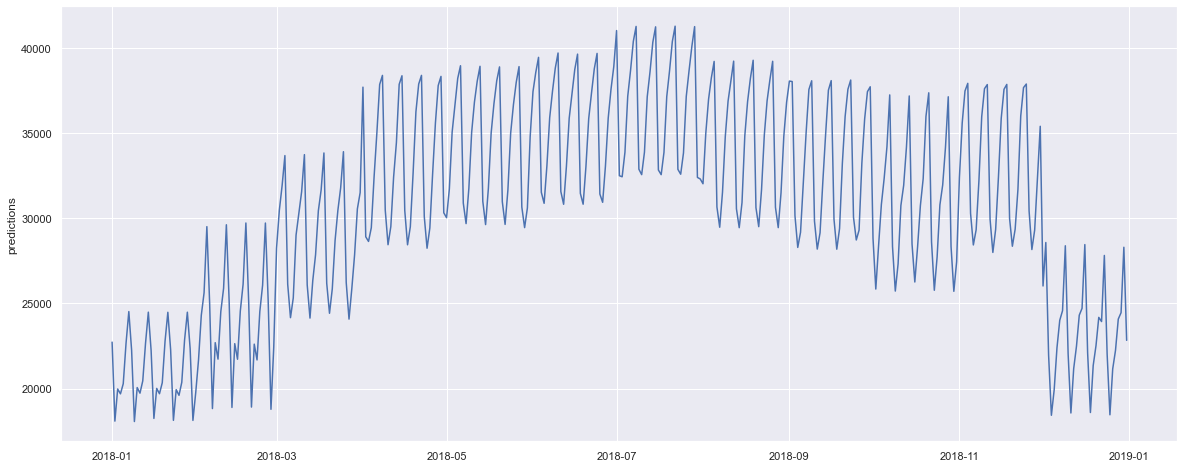

In [197]:
sns.color_palette("cubehelix", as_cmap=True)
sns.set(rc={'figure.figsize':(20,8)})
sns.lineplot(data = future_df_with_features['predictions'])

<div style="color:white; font-size:125%; text-align:left; display:fill; border-radius:5px; background-color:#C71585; overflow:hidden">Thanks for reading. I hope you enjoy it and that it was helpful to you.<br>Please don't forget to follow me and give an upvote on</br>
👇👇👇
</div>

**<a href="https://www.kaggle.com/yaseminturker/" target="_blank" rel="noopener noreferrer">[Kaggle]</a> | 
<a href="https://github.com/yaseminturker" target="_blank" rel="noopener noreferrer">[GitHub]</a> |
<a href="https://www.linkedin.com/in/yasemin-turker/" target="_blank" rel="noopener noreferrer">[Linkedin]</a>**